# Binary Logistic Regression, an Overview

- **Classification** method to predict **qualitative output**.
- Logistic regression **predict the probability** that the observation belongs to each of the categories
of a qualitative output.
- Let's talk about **sigmoid function** below.

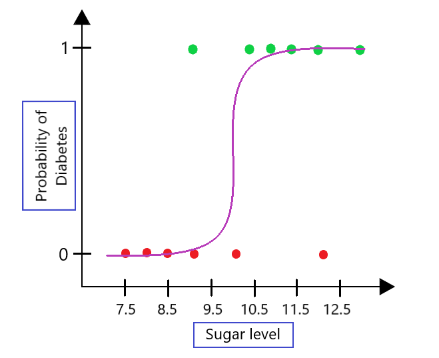

- Output in **binary logistic regression** are encoded as a “1” (indicating a “success”) or a “0” (indicating a “failure/not success”)

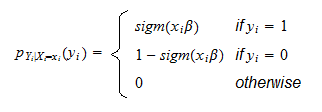 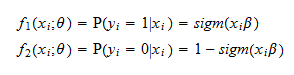 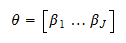
- **Sigmoid value** or y axis in sigmoid function refers to **probability that the observation belongs to class/category 1**. These values can only go from **0 to 1**, with formula:

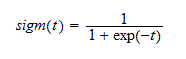

- With sigmoid function, we can transform sigmoid curve into linear curve. It is called **logit (log odds) transformation**.

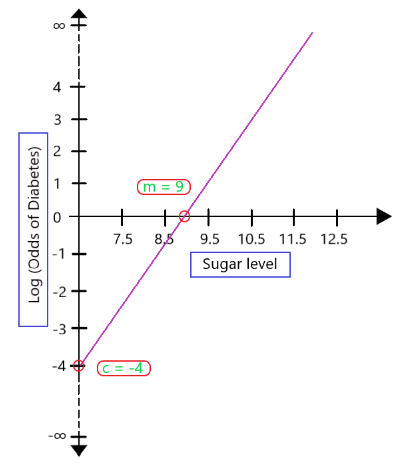

- The odds following by log odds:

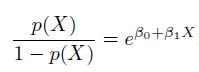 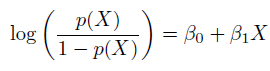

- The parameter coefficients β0 and β1 are unknown and must be estimated based on the available training data.
- We use **Maximum Likelihood Estimation (MLE)** to estimate the parameter, with likelihood function:

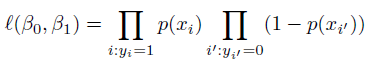

- Transforming the likelihood function above:

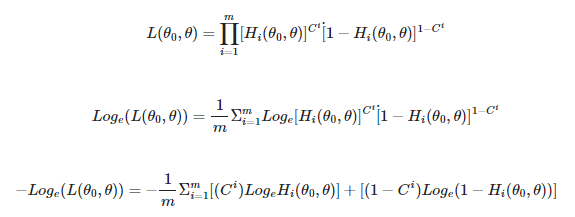

- The last equation above, **negative log likelihood** or **log loss** is the cost function that we want to minimize. Why is it multiplied by -1? Find it [here](https://www.analyticsvidhya.com/blog/2020/11/binary-cross-entropy-aka-log-loss-the-cost-function-used-in-logistic-regression/).

- After adding **Ridge Regularization**, cost function will be:

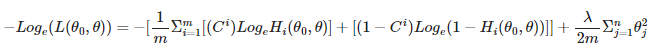

- By optimizing cost function at minimum value, we will find optimum parametercoefficients β0 and β1 for logistic regression model. In this project, we will use **Gradient Descent algorithm to minimize the cost function log loss**.

# Binary Logistic Regression with Ridge Regularization, Step by Step

**1. Load Data**
- Define variable y (output/target)
 
**2. Split Data**
- Split data into training and testing data
- Split data training into variabel X (predictor/features) and variabel y (output/target)
    
**3. Standardize Data**

**4. Initialize Parameter (Intercet and Slope)**

**5. Compute Sigmoid Value**
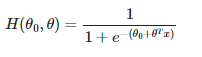

**6. Compute Cost Function [(Negative Log Likelihood)](https://www.analyticsvidhya.com/blog/2020/11/binary-cross-entropy-aka-log-loss-the-cost-function-used-in-logistic-regression/) with Ridge Regularization**
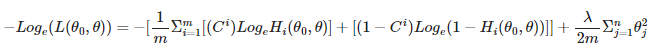

**7. Calculate Derivative of Cost Function**
- Derivative of cost function w.r.t intercept
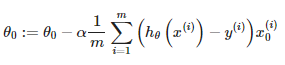
- Derivative of cost function w.r.t slope
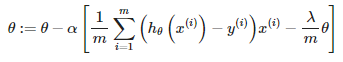
    
**8. Minimize Cost Function Using Gradient Descent Algorithm**
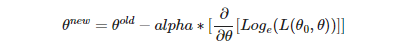

**9. Predict and Evaluate Model**
- Predict and evaluate the model on training data
- Predict and evaluate the model on testing data

# Step by Step Code

## 1. Load Data

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore")

In [2]:
# Load Data and label the columns
data = pd.read_csv("diabetes.csv")
data = data[["Glucose", "BloodPressure", "Outcome"]]

# Remove observations with glucose == 0 & blood pressure == 0
condition_1 = data["Glucose"] > 0
condition_2 = data["BloodPressure"] > 0

data = data[condition_1 & condition_2]
data

,Glucose,BloodPressure,Outcome
0,148,72,1
1,85,66,0
2,183,64,1
3,89,66,0
4,137,40,1
...,...,...,...
763,101,76,0
764,122,70,0
765,121,72,0
766,126,60,1


In [3]:
# Define variable output/target or variable y 
output_label="Outcome"
variable_y = np.array(data[output_label])

# Checking proportions of each category in variable y
def category_proportions(variable_y):
    
    category, counts = np.unique(variable_y, return_counts=True)
    proportions_of_category = dict(zip(category, counts/len(variable_y)))
    
    return proportions_of_category

category_proportions(variable_y)

{0: 0.6565934065934066, 1: 0.3434065934065934}

## 2. Split Data 

In [4]:
# Function to split data into training data and testing data
def split_train_test(data_to_split, split_ratio):
 
    # Shuffle data
    shuffle_data = data_to_split.sample(frac=1)

    # Calculate size of training sample and testing sample
    total_rows = shuffle_data.shape[0]
    train_size = int(total_rows*split_ratio)
    test_size = total_rows - train_size
 
    # Split data into training data and testing data
    data_train = shuffle_data[0:train_size]
    data_test = shuffle_data[train_size:]

    return data_train, data_test, train_size, test_size

# Split data into 80% training data and 20% testing data
data_train, data_test, train_size, test_size = split_train_test(data, 0.8)

data_train

,Glucose,BloodPressure,Outcome
482,85,58,0
416,97,68,0
356,125,50,1
556,97,70,0
761,170,74,1
...,...,...,...
659,80,82,1
568,154,72,0
278,114,74,0
609,111,62,0


In [5]:
# Function to define variable input (X) and variable output (y) for modelling
def split_input_output(data_to_split,output_label):
    
    X = data_to_split.drop(labels=output_label,axis=1)
    y = np.array(data_to_split[output_label])
    
    return X, y

# Define X and y in training data
X_train, y_train = split_input_output(data_train,output_label)
X_train = np.array(X_train)

# Checking proportions of each category in variable y_train
category_proportions(y_train)

{0: 0.6563573883161512, 1: 0.3436426116838488}

In [6]:
# Calculate baseline prior class probability
odds_class_1 = category_proportions(variable_y)[0]*category_proportions(y_train)[0]
odds_class_0 = category_proportions(variable_y)[1]*category_proportions(y_train)[1]

odds_total = odds_class_1 + odds_class_0
odds_total

0.5489690721649485

## 3. Standardize Data

In [7]:
# Function to standardize variable input (X)
def standardize(variable_to_standardize):
    
    X = np.array(variable_to_standardize)
    mean_X = np.mean(X, axis=0)
    std_X = np.std(X, axis=0)
    
    standardized_X = (X - mean_X)/std_X
    
    return standardized_X

# Standardize variable X of training data
standardized_X_train = standardize(X_train)

standardized_X_train

array([[-1.19492924, -1.17898602],
       [-0.81262195, -0.37794719],
       [ 0.07942839, -1.81981709],
       ...,
       [-0.27101996,  0.10267611],
       [-0.36659678, -0.85857049],
       [ 0.74846615, -0.21773942]])

## 4. Initialize Parameter (Intercept and Slope)

In [8]:
# Define initial parameter theta0 and matrix theta
def initial_parameter(standardized_X_train):
    
    theta0_initial = np.random.randn(1,1)
    theta_initial = np.random.randn(standardized_X_train.shape[1],1)
    
    return theta0_initial, theta_initial

## 5. Compute Sigmoid Value

In [9]:
# Calculate sigmoid value of each observation
def sigmoid(standardized_X,theta0,theta):
    
    power = theta0 + np.dot(standardized_X,theta)
    y_pred = 1/(1+ np.exp(-power))
    
    return y_pred

## 6. Compute Cost Function

In [10]:
# Calculate negative log likelihood (log loss) with Ridge Regularization
def cost_function(y_train,y_pred,theta,standardized_X_train,lam):
    
    log_like_1 = np.matmul((y_train.T),np.log(y_pred))
    log_like_0 = np.matmul(((1-y_train).T),np.log(1-y_pred))
    ridge = (lam*np.sum(np.square(theta)))/2*train_size
    neg_log_likelihood = -((log_like_1 + log_like_0)/train_size) + ridge
    
    return neg_log_likelihood

## 7. Calculate Derivative of Cost Function

In [11]:
# Calculate derivative of cost function w.r.t theta0 (b0)
def derivative_theta0(diff_y):
    
    d_theta0 = (np.sum(diff_y))/train_size
    
    return d_theta0


# Calculate derivative of cost function w.r.t theta (matrix B)
def derivative_theta(diff_y,standardized_X_train,lam,theta):
    
    # Adding Ridge (L2) Reguralization
    d_theta = ((np.matmul((standardized_X_train.T),diff_y))/train_size)-((lam/train_size)*theta)
    
    return d_theta

## 8. Minimize Cost Function using Gradient Descent

In [12]:
# Gradient Descent to minimize negative log likelihood (log loss)
def gradient_descent(alpha,epsilon,standardized_X_train,y_train,lam):
    # Alpha is learning rate
    # Epsilon to stop gradient descent at optimum solution
    # Lambda is paramater for Ridge Regularization
    
    # Define initial theta0 and theta
    theta0_initial,theta_initial=initial_parameter(standardized_X_train)
    
    i=0
    iterations=[]
    log_loss=[]
    
    while(True):
        
        # Calculate sigmoid value or probability of y = 1 (y_pred)
        y_pred = sigmoid(standardized_X_train,theta0_initial,theta_initial)
        
        # Calculate difference between calculated y_pred (prediction) and y_train (actual)
        y_train=np.reshape(y_train,(data_train.shape[0],1))
        diff_y = y_pred - y_train
        
        # Calculate derivative of cost function w.r.t theta0 and theta
        d_theta0 = derivative_theta0(diff_y)
        d_theta = derivative_theta(diff_y,standardized_X_train,lam,theta_initial)
        
        # Calculate negative log likelihood
        log_loss_initial = cost_function(y_train,y_pred,theta_initial,standardized_X_train,lam)
        
        # Updating theta0 and theta
        theta0_final = theta0_initial - alpha*d_theta0
        theta_final = theta_initial - alpha*d_theta
           
        # Calculate sigmoid value of theta0_final and theta_final
        y_pred_final = sigmoid(standardized_X_train,theta0_final,theta_final)
    
        # Calculate negative log likelihood of theta0_final and theta_final
        log_loss_final = cost_function(y_train,y_pred_final,theta_final,standardized_X_train,lam)
        
        if abs(log_loss_initial - log_loss_final) < epsilon:
            return theta0_final,theta_final,iterations,log_loss
            break
        
        # Updating theta0 and theta for the next iteration
        theta0_initial = theta0_final
        theta_initial = theta_final
        
        # Adding new iteration
        i += 1
        iterations.append(i)
        log_loss.append(log_loss_initial)

In [13]:
# Minimize the cost function
theta0_final,theta_final,iterations,log_loss = gradient_descent(0.3,0.00001,standardized_X_train,y_train,0.00001)

In [14]:
# Define the optimum parameter b0 and B
theta0_final, theta_final

(array([[-0.8228815]]),
 array([[1.1486135 ],
        [0.27128884]]))

In [15]:
# Checking optimum log loss and iteration
print('Minimum value of log loss is', min(log_loss) ,'at iteration', len(iterations))

Minimum value of log loss is [[0.50869189]] at iteration 63


Text(0.5, 1.0, 'Minimization Curve of Cost Function')

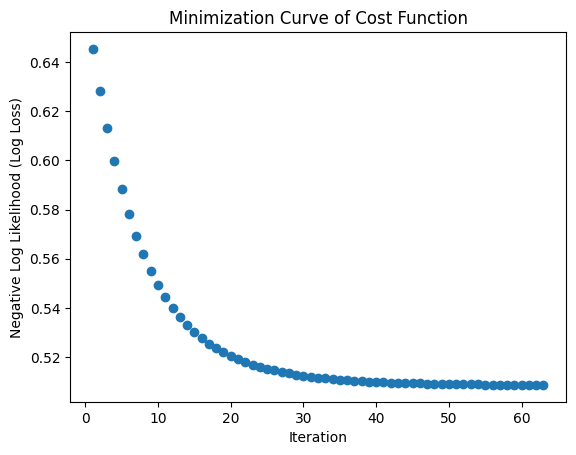

In [16]:
# Plotting minimization curve of cost function
plt.scatter(iterations, log_loss)
plt.xlabel('Iteration')
plt.ylabel('Negative Log Likelihood (Log Loss)')
plt.title('Minimization Curve of Cost Function')

## 9. Predict and Evaluate the Model

In [17]:
# Function to predict and evaluate the model on training and testing data
def predict(X_to_predict,y_actual,theta0,theta):
    
    # Define list of predicted y
    output_list=[]
    
    # Calculate sigmoid value
    predict_proba = sigmoid(X_to_predict,theta0_final,theta_final)
    
    # Define output y=1 or y=0
    for i in predict_proba:
        if i>=0.50:
            output_list.append(1)
        else:
            output_list.append(0)
    
    y_pred = np.array(output_list)
    
    # Calculate the confusion matrix
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in range(len(y_actual)):
        if y_pred[i]==1 and y_actual[i]==1:
            TP += 1
        elif y_pred[i]==1 and y_actual[i]==0:
            FP += 1
        elif y_pred[i]==0 and y_actual[i]==1:
            FN += 1
        else:
            TN += 1
    
    matrix = np.array([[TP,FN],[FP,TN]])
    
    print("Accuracy : ", (TP+TN)/(TP+TN+FP+FN))
    print("Precision : ", TP/(TP+FP))
    print("Recall : ", TP/(TP+FN))
    print("F1-Score : ", (2*TP)/(2*TP+FP+FN))
    
    print("\nConfusion Matrix :\n\n", matrix)
    
    print("\nTrue Positive =",TP)
    print("False Positive =",FP)
    print("False Negative =",FN)
    print("True Negative =",TN)

In [18]:
# Predict and evaluate the model on training data
predict(standardized_X_train,y_train,theta0_final,theta_final)

Accuracy :  0.7577319587628866
Precision :  0.6928104575163399
Recall :  0.53
F1-Score :  0.6005665722379604

Confusion Matrix :

 [[106  94]
 [ 47 335]]

True Positive = 106
False Positive = 47
False Negative = 94
True Negative = 335


In [19]:
# Pre-processing testing data
# Split variable X and y
X_test, y_test = split_input_output(data_test,output_label)

# Standardize X_test
standardized_X_test = standardize(X_test)

# Predict and evaluate the model on testing data
predict(standardized_X_test,y_test,theta0_final,theta_final)

Accuracy :  0.726027397260274
Precision :  0.6666666666666666
Recall :  0.4
F1-Score :  0.5

Confusion Matrix :

 [[20 30]
 [10 86]]

True Positive = 20
False Positive = 10
False Negative = 30
True Negative = 86


## 10. Checking Output from Statsmodels

In [20]:
# Import library statsmodels
import statsmodels.formula.api as smf

# Function for model fitting 
def modelling(formula):

    model = smf.logit(formula, data=data_train).fit()
    
    return model

In [21]:
# Define logit formula 
with_intercept = "y_train ~ standardized_X_train"
without_intercept = "y_train ~ standardized_X_train"

In [22]:
# Modelling logit formula
model = modelling(with_intercept)
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.504346
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                y_train   No. Observations:                  582
Model:                          Logit   Df Residuals:                      579
Method:                           MLE   Df Model:                            2
Date:                Thu, 23 Mar 2023   Pseudo R-squ.:                  0.2162
Time:                        10:11:57   Log-Likelihood:                -293.53
converged:                       True   LL-Null:                       -374.47
Covariance Type:            nonrobust   LLR p-value:                 7.033e-36
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.8215      0.105     -7.821      0.000      -1.027   

In [23]:
# Compare final theta to coef and 95% CI from statsmodels

theta0_final, theta_final

(array([[-0.8228815]]),
 array([[1.1486135 ],
        [0.27128884]]))

In [24]:
from sklearn.metrics import (confusion_matrix, accuracy_score)

# Predict and evaluate the model

def predict_evaluate(X, y):
    
    # performing prediction on data
    yhat = model.predict(X)
    prediction = list(map(round, yhat))

    # confusion matrix
    cm = confusion_matrix(y, prediction) 

    print("Confusion Matrix : \n", cm) 
  
    # accuracy score of the model
    print('Accuracy = ', accuracy_score(y, prediction))

In [25]:
# predict_evaluate(standardized_X_train, y_train)